# ***Analiza S&P500 z danymi makroekonomicznymi***

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from fredapi import Fred
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree as xgb_plot_tree
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_curve, auc, mean_squared_error,
                             mean_absolute_error, r2_score)

: 

### *Wczytanie danych S&P500*

In [ ]:
# Pobranie danych dziennych S&P500 z API AlphaVantage
api_key = 'JK6HINRTB8X9ACNM'
symbol = 'SPY'
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={api_key}&outputsize=full"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    
    if "Time Series (Daily)" in data:
        df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient='index')
        df.index = pd.to_datetime(df.index)
        
        df = df.rename(columns={
            '1. open': 'open', 
            '2. high': 'high', 
            '3. low': 'low', 
            '4. close': 'close', 
            '5. volume': 'volume'
        })
        
        df = df.astype(float)
        three_years_ago = pd.Timestamp('today') - pd.DateOffset(years=3)
        df3 = df[df.index >= three_years_ago]
        print(df3)

In [ ]:
# Sprawdzenie brakujących wartości w danych S&P500
missing_values = df3.isnull().sum()
missing_values

In [ ]:
# Statystyki opisowe dla danych S&P500
df3.describe()

In [ ]:
# Inflacja: CPI i Core CPI
plt.figure(figsize=(12, 6))
plt.plot(df_macro.index, df_macro['CPI'], label='CPI (Inflacja ogólna)')
plt.plot(df_macro.index, df_macro['CoreCPI'], label='Core CPI (Bez żywności i energii)', linestyle='--')
plt.title('Wskaźniki inflacyjne (CPI i Core CPI)')
plt.xlabel('Data')
plt.ylabel('Wartość indeksu (CPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Stopa bezrobocia, Fed Funds Rate, Produkcja przemysłowa
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title('Stopa bezrobocia, Fed Funds Rate i produkcja przemysłowa')
ax1.set_xlabel('Data')
ax1.set_ylabel('Stopa %', color='tab:blue')
ax1.plot(df_macro.index, df_macro['Unemployment'], label='Stopa bezrobocia', color='tab:blue')
ax1.plot(df_macro.index, df_macro['FedFundsRate'], label='Fed Funds Rate', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Indeks produkcji przemysłowej', color='tab:green')
ax2.plot(df_macro.index, df_macro['IndProd'], label='Produkcja przemysłowa', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# Wykres pudełkowy dla ceny zamknięcia S&P 500 w podziale na miesiące
df3['month'] = df3.index.to_period('M')

plt.figure(figsize=(16, 6))
sns.boxplot(data=df3, x='month', y='close', hue='month', palette='Blues', dodge=False)
plt.legend([],[], frameon=False)  # Ukrycie legendy
plt.xticks(rotation=45)
plt.title('Boxplot ceny zamknięcia S&P 500 w podziale na miesiące')
plt.xlabel('Miesiąc')
plt.ylabel('Cena zamknięcia')
plt.tight_layout()
plt.show()

In [ ]:
# Wykres liniowy dla ceny zamknięcia S&P 500 w czasie
plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3['close'], label='Cena zamknięcia')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.title('Wahania ceny zamknięcia w czasie')
plt.legend()
plt.show()

In [ ]:
# Wykres z zaznaczonymi wydarzeniami makroekonomicznymi
df3.index = pd.to_datetime(df3.index)

macro_events = {
    '2022-06-15': 'Podwyżka stóp Fed',
    '2022-09-13': 'Inflacja CPI > prognozy',
    '2023-01-27': 'Dobre dane z rynku pracy',
    '2023-10-31': 'Core CPI < oczekiwań',
    '2024-03-20': 'Fed: pauza w podwyżkach',
    '2024-12-11': 'Spadek inflacji',
    '2025-02-01': 'Wzrost bezrobocia'
}

plt.figure(figsize=(12, 6))
plt.plot(df3.index, df3['close'], label='Cena zamknięcia', color='orange', linewidth=1.5)

for date_str, label in macro_events.items():
    date = pd.to_datetime(date_str)
    if df3.index.min() <= date <= df3.index.max():
        plt.axvline(date, color='red', linestyle='--', alpha=0.7)
        plt.text(date, df3['close'].max() * 0.97, label, rotation=90, color='red', fontsize=8, ha='right', va='top')

plt.title('Cena zamknięcia S&P 500 z zaznaczonymi wydarzeniami makroekonomicznymi')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend()
plt.tight_layout()
plt.show()

# ***Budowa i wyniki modeli predykcyjnych***

### *1. Regresja liniowa*

In [ ]:
#Regresja liniowa
df3 = df3.copy()
df3['target'] = df['close'].shift(-1)
df3.dropna()

features = ['open', 'high', 'low', 'close', 'volume']
X = df3[features]
y = df3['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE dla regresji liniowej wynosi:", round(rmse, 2))
print("R^2 Score dla regresji liniowej wynosi:", round(r2, 2))

In [ ]:
#Wizualizacja wyników dla regresji liniowej: rzeczywiste ceny vs prognozowane
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label="Rzeczywista CENA S&P", color='blue')
plt.plot(y_test.index, y_pred, label="Prognozowana CENA S&P", color='red', linestyle='--')
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia")
plt.title("Prognoza ceny S&P metodą regresji liniowej")
plt.legend()
plt.show()

### *1a. Regresja liniowa z danymi makro*

In [ ]:
#Pobranie danych inflacyjnych
fred_api_key = '84fa15b195b1143cdb393900e5e61c2b'  
fred = Fred(api_key=fred_api_key)

cpi = fred.get_series('CPIAUCSL', observation_start='2020-01-01')

df_cpi = cpi.to_frame(name='CPI')
df_cpi.index.name = 'date'
df_cpi.reset_index(inplace=True)
df_cpi['inflation'] = df_cpi['CPI'].pct_change() * 100  
df_cpi = df_cpi.dropna()

df_cpi['year'] = df_cpi['date'].dt.year
df_cpi['month'] = df_cpi['date'].dt.month

df_cpi

In [ ]:
#Przygotowanie danych do modelu poszerzonego o dane inflacyjne
start_cpi = '2020-01-01'  # Początek zakresu
end_cpi = '2025-01-01'    # Koniec zakresu

start_cpi = pd.to_datetime(start_cpi)
end_cpi = pd.to_datetime(end_cpi)
df3.index = pd.to_datetime(df3.index)
df3 = df3.loc[(df3.index >= start_cpi) & (df3.index <= end_cpi)]

df3['date'] = df3.index
df3['year'] = df3.index.year
df3['month'] = df3.index.month

df_cpi = df_cpi[['year', 'month', 'inflation']]
df_merged = df3.merge(df_cpi, on=['year', 'month'], how='left')
df_merged['inflation'] = df_merged['inflation'].ffill()
df_merged.set_index('date', inplace=True)
df_merged.sort_index(inplace=True) 

In [ ]:
#Regresja liniowa + inflacja
df_merged['target'] = df_merged['close'].shift(-1)
df_merged = df_merged.dropna(subset=['target']) 

features = ['open', 'high', 'low', 'close', 'volume', 'inflation']
X = df_merged[features]
y = df_merged['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Regresja liniowa z inflacją - RMSE wynosi:", round(rmse, 2))
print("Regresja liniowa z inflacją - R^2 Score wynosi:", round(r2, 2))

In [ ]:
#Wizualizacja wyników dla regresji liniowej poszerzonej o inflacje: rzeczywiste ceny vs prognozowane
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(y_test.index, y_test, label="Rzeczywista cena S&P500", color='blue')
ax.plot(y_test.index, y_pred, label="Prognozowana cena S&P500", color='red', linestyle='--')
ax.set_xlabel("Data")
ax.set_ylabel("Cena zamknięcia")
ax.set_title("Prognoza ceny S&P500 metodą regresji liniowej\n(z uwzględnieniem inflacji z FRED)")
ax.legend()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), ha='right')
plt.tight_layout()
plt.show()

### *2. Regresja logistyczna*

In [ ]:
#Przygotowanie danych
data_logistic = df3.copy()
data_logistic['target'] = data_logistic['close'].shift(-1)
data_logistic['price_direction'] = (data_logistic['target'] > data_logistic['close']).astype(int)
fred_api_key = '84fa15b195b1143cdb393900e5e61c2b'  
fred = Fred(api_key=fred_api_key)

# 1. Zakresakres dat z danych S&P500
start = df3.index.min().strftime('%Y-%m-%d')
end   = df3.index.max().strftime('%Y-%m-%d')

# 2. Dane makro
cpi      = fred.get_series('CPIAUCSL',  observation_start=start, observation_end=end)
core_cpi = fred.get_series('CPILFESL',  observation_start=start, observation_end=end)
unrate   = fred.get_series('UNRATE',    observation_start=start, observation_end=end)
fedfunds = fred.get_series('FEDFUNDS',  observation_start=start, observation_end=end)
indprod  = fred.get_series('INDPRO',    observation_start=start, observation_end=end)

# 3. Złożenie w jeden DF i nadanie nazw
df_macro = pd.DataFrame({
    'CPI':          cpi,
    'CoreCPI':      core_cpi,
    'Unemployment': unrate,
    'FedFundsRate': fedfunds,
    'IndProd':      indprod
})

df_macro = df_macro.resample('D').ffill()

# 5. Merge z danymi SP500
data_logistic= data_logistic.join(df_macro, how='left')
data_logistic = data_logistic.dropna(subset=['CPI','CoreCPI','Unemployment','FedFundsRate','IndProd','price_direction'])

#Podział danych na zbiór treningowy i testowy
X = data_logistic[['open', 'high', 'low', 'close', 'volume', 'CPI', 'CoreCPI', 'Unemployment', 'FedFundsRate', 'IndProd']]
y = data_logistic['price_direction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Model regresji logistycznej
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność modelu regresji logistycznej wynosi:", round(accuracy, 2))

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Spadek','Wzrost']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Spadek','Wzrost'],
            yticklabels=['Spadek','Wzrost'])
plt.title('Macierz pomyłek')
plt.xlabel('Prognoza')
plt.ylabel('Rzeczywistość')
plt.show()

In [ ]:
# Krzywa ROC i AUC
probs = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.title('Krzywa ROC — regresja logistyczna')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
feature_cols = X_train.columns.tolist()

In [ ]:
#Wazność cech w modelu regresji logistycznej
coef_series = pd.Series(data=model.coef_[0], index=feature_cols)
coef_series_sorted = coef_series.abs().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
coef_series_sorted.plot(kind='barh')
plt.title('Feature Importance (Regresja Logistyczna)')
plt.xlabel('Wartość bezwzględna współczynnika')
plt.ylabel('Cecha')
plt.tight_layout()
plt.show()

In [ ]:
#AUC z walidacji krzyżowej
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_cv = LogisticRegression(max_iter=1000)

auc_scores = cross_val_score(
    model_cv,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# 4.4. Wyświetlamy wyniki
print("\nAUC w poszczególnych foldach CV:", np.round(auc_scores, 3))
print(f"Najniższe AUC w CV: {auc_scores.min():.3f}")
print(f"Najwyższe AUC w CV: {auc_scores.max():.3f}")
print(f"Średnie AUC w CV:   {auc_scores.mean():.3f} (±{auc_scores.std():.3f})")

### *3. Drzewo decyzyjne*

In [ ]:
# 1. Inicjalizacja i trening drzewa
dt_model = DecisionTreeClassifier(
    max_depth=5,         
    min_samples_leaf=10, 
    random_state=42
)
dt_model.fit(X_train, y_train)

# 2. Predykcja i metryki
y_pred_dt = dt_model.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (drzewo decyzyjne): {acc_dt:.2f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred_dt, target_names=['Spadek','Wzrost']))

cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Spadek','Wzrost'],
            yticklabels=['Spadek','Wzrost'])
plt.title('Macierz pomyłek (Drzewo decyzyjne)')
plt.xlabel('Prognoza')
plt.ylabel('Rzeczywistość')
plt.show()

# 3. Wizualizacja drzewa
plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=feature_cols,
    class_names=['Spadek','Wzrost'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

# 4. Ważność cech
importances = pd.Series(
    dt_model.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.plot(kind='bar')
plt.title('Feature Importances (Drzewo decyzyjne)')
plt.xlabel('Cechy')
plt.ylabel('Znaczenie')
plt.tight_layout()
plt.show()

In [ ]:
#Krzywa ROC
probs_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, probs_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(6, 6))
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {roc_auc_dt:.2f}', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Krzywa ROC — Drzewo decyzyjne')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Walidacja krzyżowa dla drzewa decyzyjnego
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_model_cv = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

auc_scores_dt = cross_val_score(
    dt_model_cv,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("\nAUC w poszczególnych foldach CV (Drzewo):", np.round(auc_scores_dt, 3))
print(f"Najniższe AUC w CV: {auc_scores_dt.min():.3f}")
print(f"Najwyższe AUC w CV: {auc_scores_dt.max():.3f}")
print(f"Średnie AUC w CV:   {auc_scores_dt.mean():.3f} (±{auc_scores_dt.std():.3f})")

### *4. Random Forrest*

In [ ]:
# GridSearchCV + Pipeline
tscv = TimeSeriesSplit(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [3, 5, 7, None],
    'clf__min_samples_leaf': [5, 10, 20]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Ocena najlepszego modelu na zbiorze testowym
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(f"\nTest accuracy (RF): {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=['Spadek', 'Wzrost']))

# Macierz pomyłek 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Spadek','Wzrost'],
            yticklabels=['Spadek','Wzrost'])
plt.title('Macierz pomyłek (RandomForest)')
plt.xlabel('Prognoza')
plt.ylabel('Rzeczywistość')
plt.tight_layout()
plt.show()

# feature importances
rf = best_model.named_steps['clf']  # Wyciągamy model RandomForest z pipeline
feature_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,4))
feature_importances.plot(kind='bar')
plt.title('Feature Importances (RandomForest)')
plt.ylabel('Znaczenie')
plt.tight_layout()
plt.show()

In [ ]:
#Krzywa ROC
probs_rf = best_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {roc_auc_rf:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Krzywa ROC — Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Walidacja krzyżowa dla Random Forest
auc_scores_rf = cross_val_score(
    estimator=pipeline,   
    X=X_train,
    y=y_train,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1
)

print("\nAUC w poszczególnych foldach CV (Random Forest):", np.round(auc_scores_rf, 3))
print(f"Najniższe AUC w CV:  {auc_scores_rf.min():.3f}")
print(f"Najwyższe AUC w CV: {auc_scores_rf.max():.3f}")
print(f"Średnie AUC w CV:   {auc_scores_rf.mean():.3f} (±{auc_scores_rf.std():.3f})")

## *5. XGBoost*

In [ ]:
# GridSearchCV + Pipeline dla XGBoost
tscv = TimeSeriesSplit(n_splits=5)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',    XGBClassifier(eval_metric='logloss', random_state=42))
])

param_grid = {
    'clf__n_estimators':    [50, 100, 200],
    'clf__max_depth':       [3, 5, 7],
    'clf__learning_rate':   [0.01, 0.1, 0.2],
    'clf__subsample':       [0.6, 0.8, 1.0]
}

grid_xgb = GridSearchCV(pipeline, param_grid, cv=tscv,
                        scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV acc:", grid_xgb.best_score_)

# Ocena na teście
xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
print("Test accuracy (XGB):", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Spadek','Wzrost']))

In [ ]:
# Macierz pomyłek dla XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Spadek', 'Wzrost'],
    yticklabels=['Spadek', 'Wzrost']
)
plt.title('Macierz pomyłek (XGBoost)')
plt.xlabel('Prognoza')
plt.ylabel('Rzeczywistość')
plt.tight_layout()
plt.show()

In [ ]:
# feature importances dla XGBoost
xgb_clf = grid_xgb.best_estimator_.named_steps['clf']

# Ważność cech
feat_imps = pd.Series(
    xgb_clf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

# Wykres
plt.figure(figsize=(8,4))
feat_imps.plot(kind='bar')
plt.title('Feature Importances (XGB)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Krzywa ROC
probas = xgb_best.named_steps['clf'].predict_proba(
    xgb_best.named_steps['scaler'].transform(X_test)
)[:,1]

fpr, tpr, _ = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], '--', color='gray')
plt.title('ROC Curve — XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### *Ogólny wpływ zmiennych makroekonomicznych na skuteczność modeli*

In [ ]:
X_all = data_logistic[['open', 'high', 'low', 'close', 'volume',
                       'CPI', 'CoreCPI', 'Unemployment',
                       'FedFundsRate', 'IndProd']]
y = data_logistic['price_direction']

X_train, X_test, y_train, y_test = train_test_split(
        X_all, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

cols_market = ['open', 'high', 'low', 'close', 'volume']
base_idx = [X_all.columns.get_loc(c) for c in cols_market]

clf_base = LogisticRegression(max_iter=1000, penalty='l2').fit(
        X_train_s[:, base_idx], y_train)
acc_base = accuracy_score(y_test, clf_base.predict(X_test_s[:, base_idx]))


clf_full = LogisticRegression(max_iter=1000, penalty='l2').fit(
        X_train_s, y_train)
acc_full = accuracy_score(y_test, clf_full.predict(X_test_s))

improvement = {}
for col in ['CPI', 'CoreCPI', 'Unemployment', 'FedFundsRate', 'IndProd']:
    feats = cols_market + [col]

    scaler_part = StandardScaler()
    X_tr = scaler_part.fit_transform(X_train[feats])
    X_te = scaler_part.transform(X_test[feats])

    clf_part = LogisticRegression(max_iter=1000, penalty='l2').fit(X_tr, y_train)
    acc_part = accuracy_score(y_test, clf_part.predict(X_te))
    improvement[col] = acc_part - acc_base

improvement['All_Macro'] = acc_full - acc_base

results = (
    pd.DataFrame({
        'Accuracy': [acc_base] + [acc_base + v for v in improvement.values()],
        'Δ vs Base (p.p.)': [0] + [round(v * 100, 2) for v in improvement.values()]
    },
    index=['Base_only'] + list(improvement.keys()))
    .sort_values('Accuracy', ascending=False)
)

print('\nTabela porównawcza modeli:\n')
print(results.to_string())

plt.figure(figsize=(8, 4))
(results.loc[results.index != 'Base_only', 'Δ vs Base (p.p.)']
         .sort_values(ascending=False)
         .plot(kind='bar', color='steelblue'))
plt.ylabel('Przyrost accuracy (punkty proc.)')
plt.title('Wpływ dodania poszczególnych wskaźników makro')
plt.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

best_two = results.drop('Base_only')['Δ vs Base (p.p.)'].nlargest(2)

print(
    f'\nNajwiększy indywidualny przyrost daje: {best_two.index[0]} '
    f'({best_two.iloc[0]} p.p.),\n'
    f'drugie miejsce: {best_two.index[1]} '
    f'({best_two.iloc[1]} p.p.).\n'
    f'Dodanie wszystkich zmiennych makro łącznie podnosi accuracy o '
    f'{round(improvement["All_Macro"] * 100, 2)} p.p. względem modelu bazowego.'
)

### *Analiza szeregów czasowych w kontekście zdarzeń makroekonomicznych*

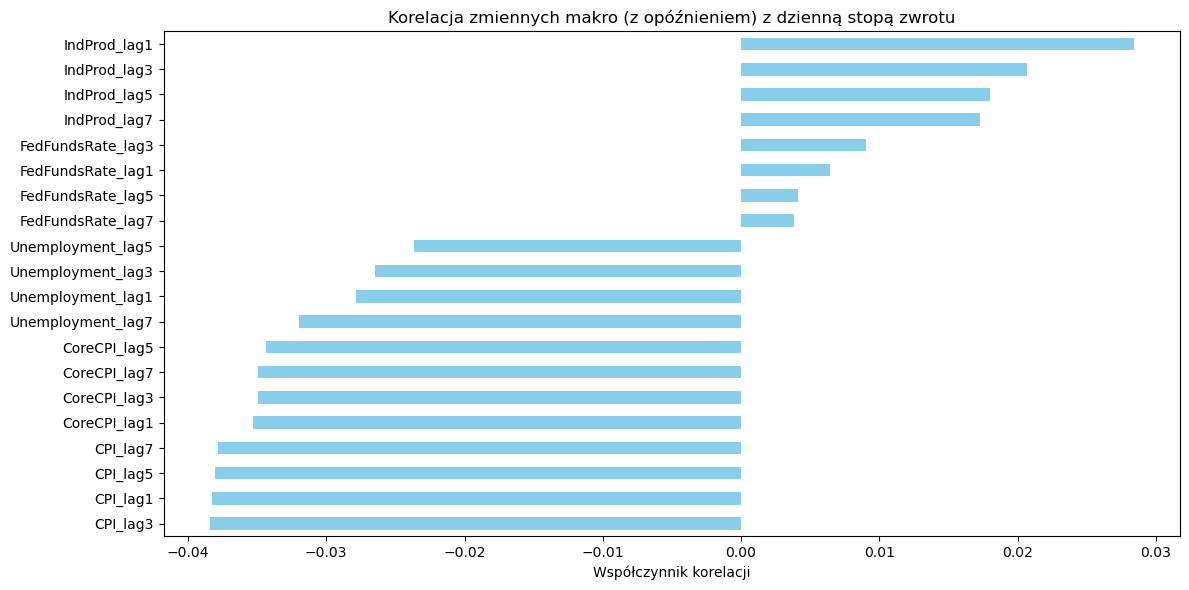

R² modelu regresji liniowej: 0.0253


In [32]:
fred = Fred(api_key=fred_api_key)

start_date = '2022-05-01'
end_date = '2025-05-01'
dates = pd.date_range(start=start_date, end=end_date, freq='B')
df3 = pd.DataFrame(index=dates)

# Symulacja notowań indeksu
np.random.seed(42)
df3['close'] = np.cumsum(np.random.normal(0.3, 2, len(df3))) + 400
df3['daily_return'] = df3['close'].pct_change()

# Dane makroekonomiczne
macro_series = {
    'CPI': 'CPIAUCSL',
    'CoreCPI': 'CPILFESL',
    'Unemployment': 'UNRATE',
    'FedFundsRate': 'FEDFUNDS',
    'IndProd': 'INDPRO'
}

for name, code in macro_series.items():
    series = fred.get_series(code, observation_start=start_date, observation_end=end_date)
    df3[name] = series

df3 = df3.ffill()

# LAGI
for col in macro_series.keys():
    for lag in [1, 3, 5, 7]:
        df3[f'{col}_lag{lag}'] = df3[col].shift(lag)

# Regresja i korelacje
cols_with_lags = [col for col in df3.columns if 'lag' in col]
df_model = df3.dropna(subset=cols_with_lags + ['daily_return'])

X = df_model[cols_with_lags]
y = df_model['daily_return']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

corr = df_model[cols_with_lags + ['daily_return']].corr()
corr_with_return = corr['daily_return'].drop('daily_return')

# Wykres
corr_with_return.sort_values().plot(kind='barh', figsize=(12, 6), color='skyblue')
plt.title('Korelacja zmiennych makro (z opóźnieniem) z dzienną stopą zwrotu')
plt.xlabel('Współczynnik korelacji')
plt.tight_layout()
plt.show()

print(f"R² modelu regresji liniowej: {round(r2, 4)}")

## *Wykorzytsanie XGBoost do strategii inwestycyjnej*

In [ ]:
# 1. Dodajemy kolumnę ze zwrotem dziennym
data_logistic['return'] = data_logistic['close'].pct_change().shift(-1)

# 2. Predykcje modelu XGBoost
X_test_scaled = xgb_best.named_steps['scaler'].transform(X_test)
y_pred_signal = xgb_best.named_steps['clf'].predict(X_test_scaled)

# 3. Zastosowanie sygnału do strategii
returns = X_test.copy()
returns['true_return'] = data_logistic.loc[X_test.index, 'return']
returns['signal'] = y_pred_signal
returns['strategy_return'] = returns['true_return'] * returns['signal']

# 4. Skumulowane zwroty
returns['cum_market'] = (1 + returns['true_return']).cumprod()
returns['cum_strategy'] = (1 + returns['strategy_return']).cumprod()

# 5. Wykres porównujący wyniki
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(returns['cum_market'], label='Buy & Hold (S&P500)')
plt.plot(returns['cum_strategy'], label='Strategia XGBoost')
plt.title('Porównanie strategii inwestycyjnych')
plt.ylabel('Skumulowany zwrot')
plt.xlabel('Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
### Wykorzytsanie XGBoost w strategii inwestycyjnej
# 1. Predykcja na całym zbiorze
X_scaled = scaler.transform(X)
y_pred_full = xgb_best.predict(X_scaled)
data_logistic['predicted_direction'] = y_pred_full
data_logistic['predicted_direction'] = data_logistic['predicted_direction'].shift(1)
data_logistic['predicted_direction'] = data_logistic['predicted_direction'].fillna(0)
data_logistic['predicted_direction'] = data_logistic['predicted_direction'].astype(int)
data_logistic['predicted_direction'] = data_logistic['predicted_direction'].replace({0: -1})
data_logistic['predicted_direction'].value_counts()
# 2. Strategia inwestycyjna
data_logistic['strategy_return'] = data_logistic['predicted_direction'] * data_logistic['close'].pct_change()
data_logistic['strategy_return'] = data_logistic['strategy_return'].fillna(0)
data_logistic['cumulative_strategy_return'] = (1 + data_logistic['strategy_return']).cumprod()
data_logistic['cumulative_market_return'] = (1 + data_logistic['close'].pct_change()).cumprod()
# 3. Wizualizacja wyników strategii
plt.figure(figsize=(12, 6))
plt.plot(data_logistic.index, data_logistic['cumulative_strategy_return'], label='Strategia inwestycyjna', color='blue')
plt.plot(data_logistic.index, data_logistic['cumulative_market_return'], label='Rynek', color='orange')
plt.title('Wyniki strategii inwestycyjnej vs rynek')
plt.xlabel('Data')
plt.ylabel('Skumulowany zwrot')
plt.legend()
plt.show()
# 4. Metryki strategii
cumulative_strategy_return = data_logistic['cumulative_strategy_return'].iloc[-1]
cumulative_market_return = data_logistic['cumulative_market_return'].iloc[-1]
annualized_strategy_return = (cumulative_strategy_return ** (252 / len(data_logistic))) - 1
annualized_market_return = (cumulative_market_return ** (252 / len(data_logistic))) - 1
annualized_strategy_volatility = data_logistic['strategy_return'].std() * np.sqrt(252)
annualized_market_volatility = data_logistic['close'].pct_change().std() * np.sqrt(252)
sharpe_ratio = annualized_strategy_return / annualized_strategy_volatility
print(f"Skumulowany zwrot strategii: {cumulative_strategy_return:.2f}")
print(f"Skumulowany zwrot rynku: {cumulative_market_return:.2f}")
print(f"Roczny zwrot strategii: {annualized_strategy_return:.2f}")
print(f"Roczny zwrot rynku: {annualized_market_return:.2f}")
print(f"Roczna zmienność strategii: {annualized_strategy_volatility:.2f}")
print(f"Roczna zmienność rynku: {annualized_market_volatility:.2f}")
print(f"Współczynnik Sharpe'a strategii: {sharpe_ratio:.2f}")
